In [22]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!cp -R "/content/gdrive/My Drive/Colab Notebooks/styles/" "styles/"
!cp -R "/content/gdrive/My Drive/Colab Notebooks/libs/" "libs/"
!cp -R "/content/gdrive/My Drive/Colab Notebooks/image_output/" "image_output/"
!cp -R "/content/gdrive/My Drive/Colab Notebooks/contents/" "contents/"
!cp -R "/content/gdrive/My Drive/Colab Notebooks/checkpoint_output/" "checkpoint_output/"

In [0]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import IPython.display as ipyd
import scipy.misc
from libs import utils

import warnings
warnings.filterwarnings('ignore')

In [0]:
import os
import tensorflow as tf
import numpy as np
import scipy.io

content_directory = 'contents/'
style_directory = 'styles/'

# This is the directory to store the final stylized images
output_directory = 'image_output/'
if not os.path.exists(output_directory):
  os.makedirs(output_directory)
    
# This is the directory to store the half-done images during the training.
checkpoint_directory = 'checkpoint_output/'
if not os.path.exists(checkpoint_directory):
  os.makedirs(checkpoint_directory)
    
content_path = os.path.join(content_directory, 'wonder-woman.jpg')
style_path = os.path.join(style_directory, 'starry-night.jpg')
output_path = os.path.join(output_directory, 'wonder-woman-starry-night-iteration-1000.jpg')

# please notice that the checkpoint_images_path has to contain %s in the file_name
checkpoint_path = os.path.join(checkpoint_directory, 'wonder-woman-starry-night-iteration-1000-%s.jpg')

In [0]:
import tensorflow as tf
import numpy as np
import scipy.io
import os

VGG_MEAN = [103.939, 116.779, 123.68]

VGG19_LAYERS = (
  'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',

  'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

  'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
  'relu3_3', 'conv3_4', 'relu3_4', 'pool3',

  'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
  'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

  'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
'relu5_3', 'conv5_4', 'relu5_4'
)


def net_preloaded(input_image, pooling):
  data_dict = np.load('libs/vgg19.npy', encoding='latin1').item()
  net = {}
  current = input_image
  for i, name in enumerate(VGG19_LAYERS):
    kind = name[:4]
    if kind == 'conv':
      kernels = get_conv_filter(data_dict, name)
      # kernels = np.transpose(kernels, (1, 0, 2, 3))

      bias = get_bias(data_dict, name)
      # matconvnet: weights are [width, height, in_channels, out_channels]
      # tensorflow: weights are [height, width, in_channels, out_channels]

      # bias = bias.reshape(-1)
      current = conv_layer(current, kernels, bias)
    elif kind == 'relu':
      current = tf.nn.relu(current)
    elif kind == 'pool':
      current = pool_layer(current, pooling)
    
    net[name] = current

  assert len(net) == len(VGG19_LAYERS)
  return net

def conv_layer(input, weights, bias):
  conv = tf.nn.conv2d(input, weights, strides=(1, 1, 1, 1), padding='SAME')
  return tf.nn.bias_add(conv, bias)


def pool_layer(input, pooling):
  if pooling == 'avg':
    return tf.nn.avg_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
            padding='SAME')
  else:
    return tf.nn.max_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
            padding='SAME')

# before we feed the image into the network, we preprocess it by 
# extracting the mean_pixel from it.
def preprocess(image):
  return image - VGG_MEAN

# remember to unprocess it before you plot it out and save it.
def unprocess(image):
  return image + VGG_MEAN

def get_conv_filter(data_dict, name):
  return tf.constant(data_dict[name][0], name="filter")

def get_bias(data_dict, name):
  return tf.constant(data_dict[name][1], name="biases")

In [0]:
import tensorflow as tf
import numpy as np
from functools import reduce
from PIL import Image

# feel free to try different layers
CONTENT_LAYERS = ('relu4_2', 'relu5_2')
STYLE_LAYERS = ('relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1')

VGG_MEAN = [103.939, 116.779, 123.68]

def stylize(content, styles, network_path='libs/imagenet-vgg-verydeep-19.mat', 
            iterations=1000, content_weight=5e0, content_weight_blend=0.5, style_weight=5e2, 
            style_layer_weight_exp=1,style_blend_weights=None, tv_weight=100,
            learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
            print_iterations=100, checkpoint_iterations=100, checkpoint_path=None,
            output_path=None):
    
    
  shape = (1,) + content.shape                             #content image shape : (1,433,770,3)
  style_shapes = [(1,) + style.shape for style in styles]  #style image shape : (1,600,800,3)
  content_features = {}
  style_features = [{} for _ in styles]

    
  # scale the importance of each style layers according to their depth. 
  # (deeper layers are more important if style_layers_weights > 1 (default = 1))
  layer_weight = 1.0
  style_layers_weights = {}                                # weight for different network layers
  for style_layer in STYLE_LAYERS:                                    
    style_layers_weights[style_layer] = layer_weight       #'relu1_1','relu2_1',...,'relu5_1'
    layer_weight *= style_layer_weight_exp                 # 1.0

        
  # normalize style layer weights
  layer_weights_sum = 0
  for style_layer in STYLE_LAYERS:                         #'relu1_1',..., 'relu5_1'
    layer_weights_sum += style_layers_weights[style_layer] # 5.0
  for style_layer in STYLE_LAYERS:
    style_layers_weights[style_layer] /= layer_weights_sum

        
  # FEATURE MAPS FROM CONTENT IMAGE
  # compute the feature map of the content image by feeding it into the network
  #the output net contains the features of each content layer
  g = tf.Graph()
  with g.as_default(), tf.Session() as sess:
    image = tf.placeholder('float', shape=shape)

    net = net_preloaded(image, pooling)             # {'conv1_1':Tensor,relu1_1:Tensor...}
    content_pre = np.array([preprocess(content)])   # (1,433,770,3) subtract the mean pixel
    for layer in CONTENT_LAYERS:                    #'relu4_2', 'relu5_2'
      content_features[layer] = net[layer].eval(feed_dict={image: content_pre})  

            
  # FEATURE MAPS (GRAM MATRICES) FROM STYLE IMAGE
  # compute style features of the style image by feeding it into the network
  # and calculate the gram matrix
  for i in range(len(styles)):
    g = tf.Graph()
    with g.as_default(), tf.Session() as sess:
      image = tf.placeholder('float', shape=style_shapes[i])
      net = net_preloaded(image, pooling)                           
      style_pre = np.array([preprocess(styles[i])])
      for layer in STYLE_LAYERS:              #'relu1_1', 'relu2_1',..., 'relu5_1'
        features = net[layer].eval(feed_dict={image: style_pre})  # relu_1:(1,600,800,64)
        features = np.reshape(features, (-1, features.shape[3]))  # (480000, 64)
        gram = np.matmul(features.T, features) / features.size    # (64,64)
        style_features[i][layer] = gram

                
  # make stylized image using backpropogation
  with tf.Graph().as_default():

    # Generate a random image (the output image) with the same shape as the content image
    initial = tf.random_normal(shape) * 0.256  
    image = tf.Variable(initial)
    net = net_preloaded(image, pooling)
    

    # CONTENT LOSS
    # we can adjust the weight of each content layers
    # content_weight_blend is the ratio of two used content layers in this example
    content_layers_weights = {}
    content_layers_weights['relu4_2'] = content_weight_blend 
    content_layers_weights['relu5_2'] = 1.0 - content_weight_blend      

    content_loss = 0
    content_losses = []
    for content_layer in CONTENT_LAYERS:
      # Use MSE as content losses
      # content weight is the coefficient for content loss
      content_losses.append(content_layers_weights[content_layer] * content_weight * 
              (2 * tf.nn.l2_loss(net[content_layer] - content_features[content_layer]) /
              content_features[content_layer].size))
    content_loss += reduce(tf.add, content_losses)



    # STYLE LOSS
    # We can specify different weight for different style images
    # style_layers_weights => weight for different network layers
    # style_blend_weights => weight between different style images

    if style_blend_weights is None:
      style_blend_weights = [1.0/len(styles) for _ in styles]
    else:
      total_blend_weight = sum(style_blend_weights)
      # normalization
      style_blend_weights = [weight/total_blend_weight
                             for weight in style_blend_weights]


    style_loss = 0
    # iterate to calculate style loss with multiple style images
    for i in range(len(styles)):
      style_losses = []
      for style_layer in STYLE_LAYERS:             # e.g. relu1_1
        layer = net[style_layer]                   # relu1_1 of output image:(1,433,770,64)
        _, height, width, number = map(lambda i: i.value, layer.get_shape())  
        size = height * width * number
        feats = tf.reshape(layer, (-1, number))    # (333410,64)

        # Gram matrix for the features in relu1_1 of the output image.
        gram = tf.matmul(tf.transpose(feats), feats) / size
        # Gram matrix for the features in relu1_1 of the style image
        style_gram = style_features[i][style_layer]   

        # Style loss is the MSE for the difference of the 2 Gram matrices
        style_losses.append(style_layers_weights[style_layer] * 2 * 
                            tf.nn.l2_loss(gram - style_gram) / style_gram.size)
      style_loss += style_weight * style_blend_weights[i] * reduce(tf.add, style_losses)


    # TOTAL VARIATION LOSS  
    # Total variation denoising to do smoothing; cost to penalize neighboring pixel
    # not used by the original paper by Gatys et al
    # According to the paper Mahendran, Aravindh, and Andrea Vedaldi. "Understanding deep 
    # image representations by inverting them."
    # Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition. 2015.
    tv_y_size = _tensor_size(image[:,1:,:,:])
    tv_x_size = _tensor_size(image[:,:,1:,:])
    tv_loss = tv_weight * 2 * (
      (tf.nn.l2_loss(image[:,1:,:,:] - image[:,:shape[1]-1,:,:]) /
          tv_y_size) +
      (tf.nn.l2_loss(image[:,:,1:,:] - image[:,:,:shape[2]-1,:]) /
          tv_x_size))


    #OVERALL LOSS
    loss = content_loss + style_loss + tv_loss

    train_step = tf.train.AdamOptimizer(learning_rate, beta1, beta2, epsilon).minimize(loss)

    def print_progress():
      print('     iteration: %d\n' % i)
      print('  content loss: %g\n' % content_loss.eval())
      print('    style loss: %g\n' % style_loss.eval())
      print('       tv loss: %g\n' % tv_loss.eval())
      print('    total loss: %g\n' % loss.eval())

    def imsave(path, img):
      img = np.clip(img, 0, 255).astype(np.uint8)
      Image.fromarray(img).save(path, quality=95)

    
    
    # TRAINING
    best_loss = float('inf')
    best = None
    
    with tf.Session() as sess:
        
      sess.run(tf.global_variables_initializer())
    
      if (print_iterations and print_iterations != 0):
        print_progress()
        
      for i in range(iterations):

        train_step.run()

        last_step = (i == iterations - 1)
        if last_step or (print_iterations and i % print_iterations == 0):
          print_progress()

        # store output and checkpoint images
        if (checkpoint_iterations and i % checkpoint_iterations == 0) or last_step:
          this_loss = loss.eval()
          if this_loss < best_loss:
            best_loss = this_loss
            best = image.eval()

          img_out = unprocess(best.reshape(shape[1:]))

          output_file = None
          if not last_step:
            if checkpoint_path:
                output_file = checkpoint_path % i
          else:
            output_file = output_path

          if output_file:
            imsave(output_file, img_out)
            
  print("finish stylizing.")



def _tensor_size(tensor):
  from operator import mul
  return reduce(mul, (d.value for d in tensor.get_shape()), 1)

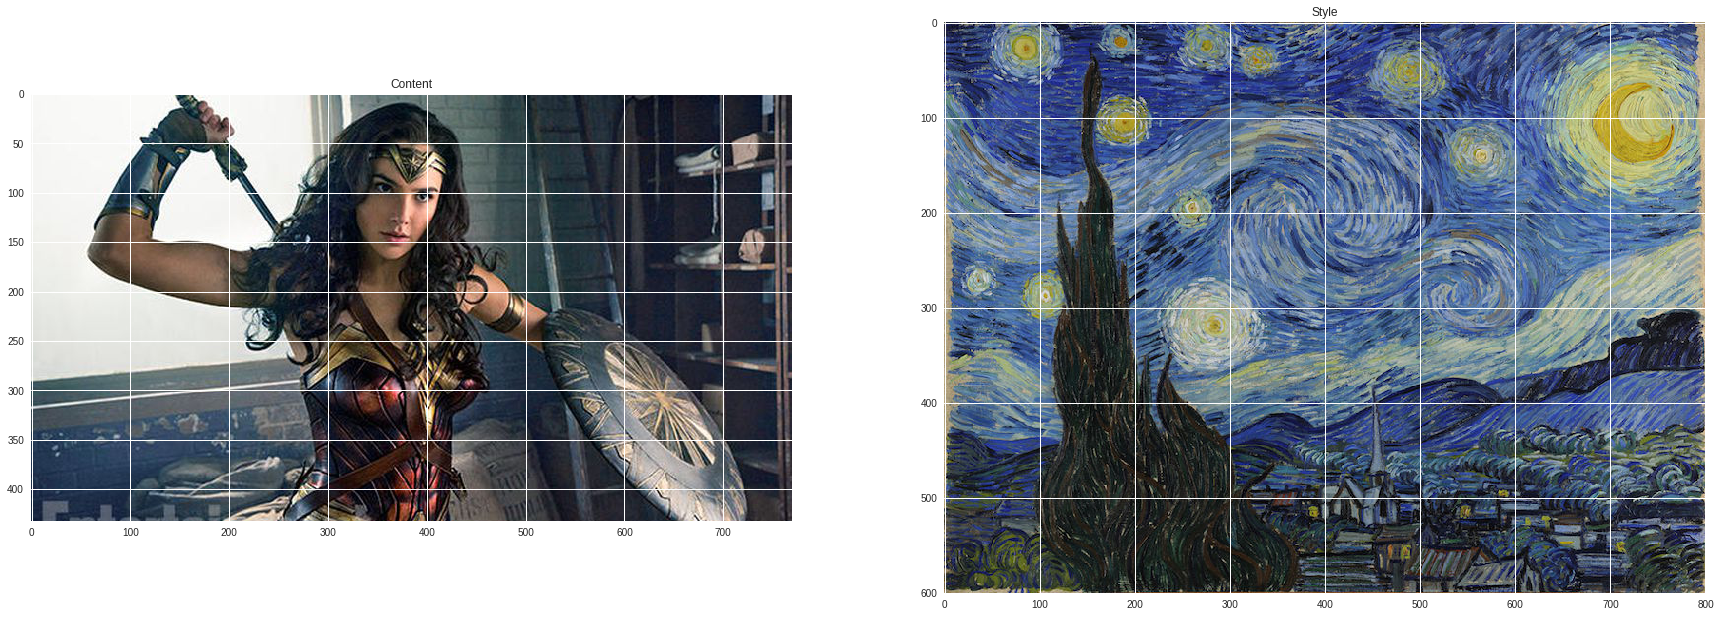

In [29]:
content_image = utils.loadImage(content_directory, 'wonder-woman.jpg')
style_image = utils.loadImage(style_directory, 'starry-night.jpg')
utils.showImage(content_image, style_image)

## content_weight=5e0 style_weight=5e2, tv_weight=100

use higher style weight will result in an image which penalize more when style is not related to the style image. Therefore, it will focus more on the style, so the result looks more like the style image.

In [30]:
checkpoint_path=None
output_path = output_directory + 'wonder-woman-starry-night-tvweight-100.jpg'

stylize(content_image, [style_image], iterations=1000,
        content_weight=5e0, content_weight_blend=1, style_weight=5e2, 
        style_layer_weight_exp=1, style_blend_weights=None, tv_weight=100,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)

     iteration: 0

  content loss: 383759

    style loss: 1.51639e+06

       tv loss: 26.2216

    total loss: 1.90018e+06

     iteration: 0

  content loss: 366403

    style loss: 1.27593e+06

       tv loss: 15659

    total loss: 1.65799e+06

     iteration: 100

  content loss: 86088.3

    style loss: 25893.6

       tv loss: 31934.3

    total loss: 143916

     iteration: 200

  content loss: 77588.3

    style loss: 24768.9

       tv loss: 29025.4

    total loss: 131383

     iteration: 300

  content loss: 75588.5

    style loss: 28499.3

       tv loss: 28672.6

    total loss: 132760

     iteration: 400

  content loss: 76207.8

    style loss: 26469.4

       tv loss: 28484.6

    total loss: 131162

     iteration: 500

  content loss: 72896.3

    style loss: 28274

       tv loss: 27953.5

    total loss: 129124

     iteration: 600

  content loss: 76305.3

    style loss: 23397.5

       tv loss: 28077.3

    total loss: 127780

     iteration: 700

  content l

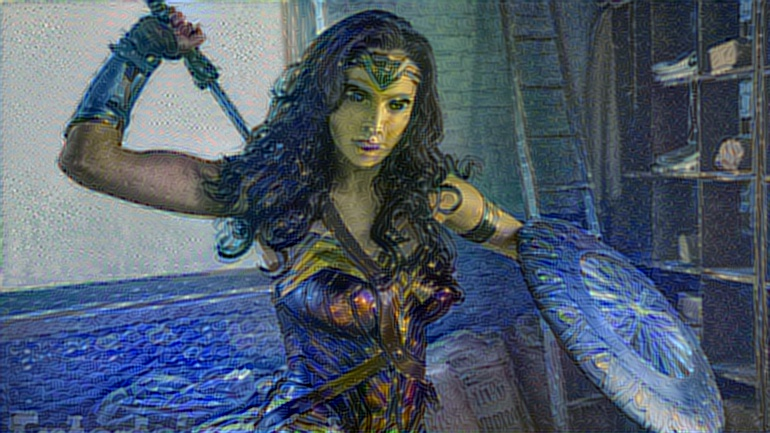

In [31]:
from IPython.display import Image
Image(output_path)

## content_weight=5e2 style_weight=5e0, tv_weight=100
use higher content weight will result in an image which penalize more when content is not related to the original image. Therefore, it will focus more on the contenct, so the result looks more like the original image.

In [32]:
from PIL import Image
checkpoint_path=None
output_path = output_directory + 'wonder-woman-starry-night-tvweight-100.jpg'

stylize(content_image, [style_image], iterations=1000,
        content_weight=5e2, content_weight_blend=1, style_weight=5e0, 
        style_layer_weight_exp=1, style_blend_weights=None, tv_weight=100,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)

     iteration: 0

  content loss: 3.83756e+07

    style loss: 15164

       tv loss: 26.1801

    total loss: 3.83908e+07

     iteration: 0

  content loss: 3.65835e+07

    style loss: 12888.8

       tv loss: 16148.9

    total loss: 3.66126e+07

     iteration: 100

  content loss: 2.65369e+06

    style loss: 7212.89

       tv loss: 222488

    total loss: 2.8834e+06

     iteration: 200

  content loss: 1.48482e+06

    style loss: 5908.66

       tv loss: 156669

    total loss: 1.6474e+06

     iteration: 300

  content loss: 1.28364e+06

    style loss: 6029.35

       tv loss: 139663

    total loss: 1.42933e+06

     iteration: 400

  content loss: 1.12466e+06

    style loss: 6085.52

       tv loss: 129457

    total loss: 1.2602e+06

     iteration: 500

  content loss: 1.10628e+06

    style loss: 6216.93

       tv loss: 124479

    total loss: 1.23697e+06

     iteration: 600

  content loss: 1.04852e+06

    style loss: 6201.27

       tv loss: 118537

    total lo

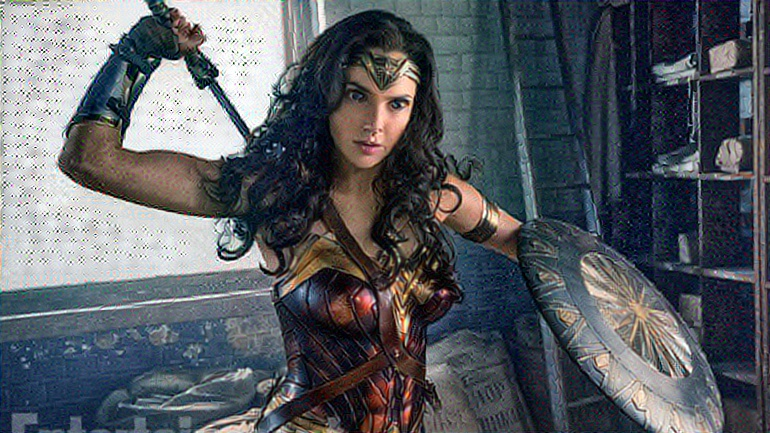

In [33]:
from IPython.display import Image
Image(output_path)

## content_weight=5e1 style_weight=5e1, tv_weight=100
use same content weight and style weight will result in a image which focus both oncontent and style. 

In [34]:
from PIL import Image
checkpoint_path=None
output_path = output_directory + 'wonder-woman-starry-night-tvweight-100.jpg'

stylize(content_image, [style_image], iterations=1000,
        content_weight=5e1, content_weight_blend=1, style_weight=5e1, 
        style_layer_weight_exp=1, style_blend_weights=None, tv_weight=100,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)

     iteration: 0

  content loss: 3.83787e+06

    style loss: 151640

       tv loss: 26.2197

    total loss: 3.98954e+06

     iteration: 0

  content loss: 3.65938e+06

    style loss: 128956

       tv loss: 16155.8

    total loss: 3.80449e+06

     iteration: 100

  content loss: 232892

    style loss: 36427.7

       tv loss: 54378.6

    total loss: 323698

     iteration: 200

  content loss: 169750

    style loss: 39295.7

       tv loss: 40574.3

    total loss: 249620

     iteration: 300

  content loss: 144585

    style loss: 42174.7

       tv loss: 34745.9

    total loss: 221505

     iteration: 400

  content loss: 138517

    style loss: 43333.7

       tv loss: 32491.7

    total loss: 214342

     iteration: 500

  content loss: 131953

    style loss: 44766.6

       tv loss: 31232.8

    total loss: 207952

     iteration: 600

  content loss: 134631

    style loss: 44749.2

       tv loss: 30106.8

    total loss: 209487

     iteration: 700

  content los

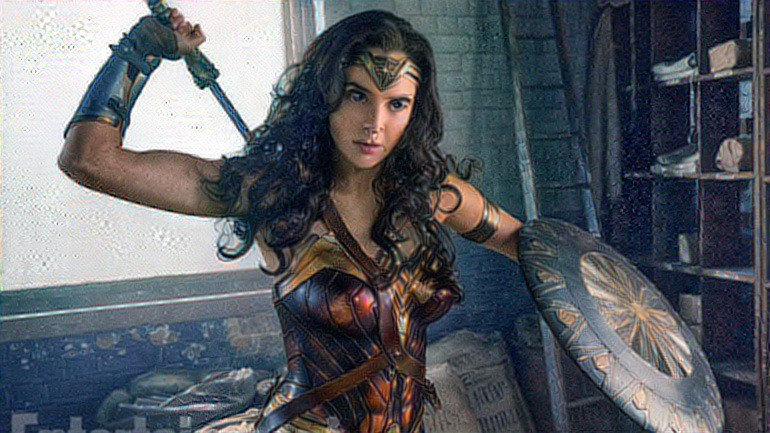

In [35]:
from IPython.display import Image
Image(output_path)

## content_weight=5e0 style_weight=5e2, tv_weight=10
lower tv weight will result in more noise in the image

In [36]:
from PIL import Image
checkpoint_path=None
output_path = output_directory + 'wonder-woman-starry-night-tvweight-100.jpg'

stylize(content_image, [style_image], iterations=1000,
        content_weight=5e0, content_weight_blend=1, style_weight=5e2, 
        style_layer_weight_exp=1, style_blend_weights=None, tv_weight=10,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)

     iteration: 0

  content loss: 383737

    style loss: 1.5164e+06

       tv loss: 2.62113

    total loss: 1.90014e+06

     iteration: 0

  content loss: 366380

    style loss: 1.27673e+06

       tv loss: 1573.42

    total loss: 1.64469e+06

     iteration: 100

  content loss: 83970.6

    style loss: 22864.1

       tv loss: 5955.63

    total loss: 112790

     iteration: 200

  content loss: 74725.3

    style loss: 22784.9

       tv loss: 4978.02

    total loss: 102488

     iteration: 300

  content loss: 72786.4

    style loss: 21424.1

       tv loss: 4754.03

    total loss: 98964.6

     iteration: 400

  content loss: 68426.7

    style loss: 27621.4

       tv loss: 4665.24

    total loss: 100713

     iteration: 500

  content loss: 74227.2

    style loss: 22126

       tv loss: 4668.6

    total loss: 101022

     iteration: 600

  content loss: 72159.5

    style loss: 25235.4

       tv loss: 4837.25

    total loss: 102232

     iteration: 700

  content 

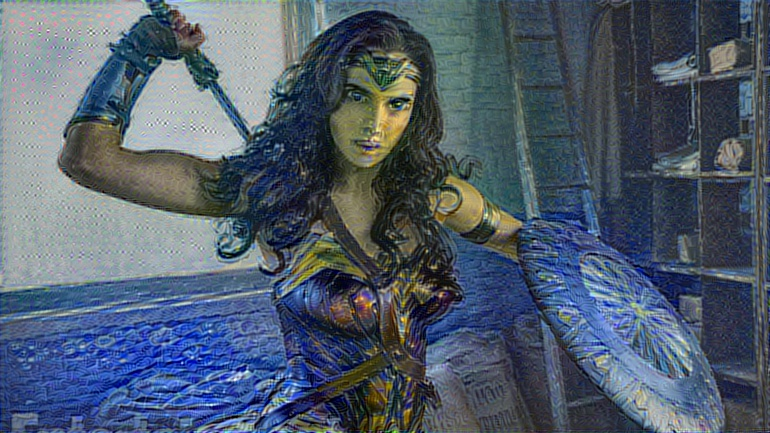

In [37]:
from IPython.display import Image
Image(output_path)

## content_weight=5e0 style_weight=5e2, tv_weight=500
higher tv weight will denoise more in the image

In [38]:
from PIL import Image
checkpoint_path=None
output_path = output_directory + 'wonder-woman-starry-night-tvweight-100.jpg'

stylize(content_image, [style_image], iterations=1000,
        content_weight=5e0, content_weight_blend=1, style_weight=5e2, 
        style_layer_weight_exp=1, style_blend_weights=None, tv_weight=500,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)

     iteration: 0

  content loss: 383780

    style loss: 1.5164e+06

       tv loss: 131.009

    total loss: 1.90031e+06

     iteration: 0

  content loss: 366431

    style loss: 1.27635e+06

       tv loss: 78375.9

    total loss: 1.72116e+06

     iteration: 100

  content loss: 95284

    style loss: 45337.5

       tv loss: 89219.1

    total loss: 229841

     iteration: 200

  content loss: 84232.9

    style loss: 45427.6

       tv loss: 83232.6

    total loss: 212893

     iteration: 300

  content loss: 86052

    style loss: 43252.1

       tv loss: 82861.2

    total loss: 212165

     iteration: 400

  content loss: 84292.4

    style loss: 44415.1

       tv loss: 81867.7

    total loss: 210575

     iteration: 500

  content loss: 84008.4

    style loss: 45186.1

       tv loss: 82188.9

    total loss: 211383

     iteration: 600

  content loss: 82340.5

    style loss: 44574.8

       tv loss: 80966.9

    total loss: 207882

     iteration: 700

  content lo

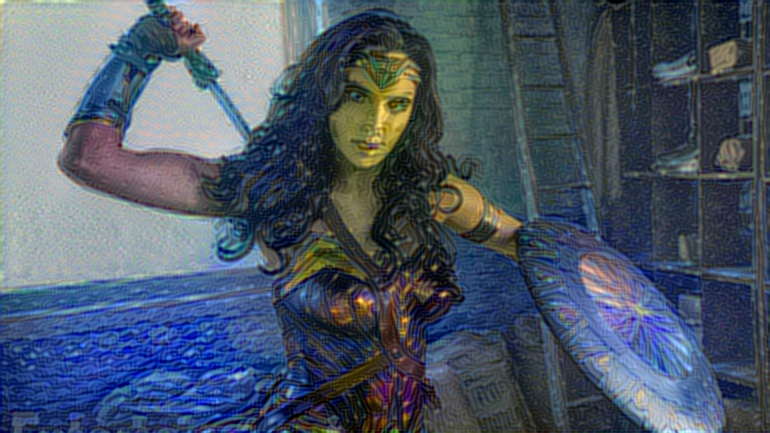

In [39]:
from IPython.display import Image
Image(output_path)

## content_layer = relu2_2, relu3_2
## style_layers = relu1_2, relu2_2, relu3_3, relu4_4, relu5_4

choosing different layer will result in different importance of content layer and style layer

In [0]:
import tensorflow as tf
import numpy as np
from functools import reduce
from PIL import Image

# feel free to try different layers
CONTENT_LAYERS = ('relu2_2', 'relu3_2')
STYLE_LAYERS = ('relu1_2', 'relu2_2', 'relu3_3', 'relu4_4', 'relu5_4')

VGG_MEAN = [103.939, 116.779, 123.68]

def stylize(content, styles, network_path='libs/imagenet-vgg-verydeep-19.mat', 
            iterations=1000, content_weight=5e0, content_weight_blend=0.5, style_weight=5e2, 
            style_layer_weight_exp=1,style_blend_weights=None, tv_weight=100,
            learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
            print_iterations=100, checkpoint_iterations=100, checkpoint_path=None,
            output_path=None):
    
    
  shape = (1,) + content.shape                             #content image shape : (1,433,770,3)
  style_shapes = [(1,) + style.shape for style in styles]  #style image shape : (1,600,800,3)
  content_features = {}
  style_features = [{} for _ in styles]

    
  # scale the importance of each style layers according to their depth. 
  # (deeper layers are more important if style_layers_weights > 1 (default = 1))
  layer_weight = 1.0
  style_layers_weights = {}                                # weight for different network layers
  for style_layer in STYLE_LAYERS:                                    
    style_layers_weights[style_layer] = layer_weight       #'relu1_1','relu2_1',...,'relu5_1'
    layer_weight *= style_layer_weight_exp                 # 1.0

        
  # normalize style layer weights
  layer_weights_sum = 0
  for style_layer in STYLE_LAYERS:                         #'relu1_1',..., 'relu5_1'
    layer_weights_sum += style_layers_weights[style_layer] # 5.0
  for style_layer in STYLE_LAYERS:
    style_layers_weights[style_layer] /= layer_weights_sum

        
  # FEATURE MAPS FROM CONTENT IMAGE
  # compute the feature map of the content image by feeding it into the network
  #the output net contains the features of each content layer
  g = tf.Graph()
  with g.as_default(), tf.Session() as sess:
    image = tf.placeholder('float', shape=shape)

    net = net_preloaded(image, pooling)             # {'conv1_1':Tensor,relu1_1:Tensor...}
    content_pre = np.array([preprocess(content)])   # (1,433,770,3) subtract the mean pixel
    for layer in CONTENT_LAYERS:                    #'relu4_2', 'relu5_2'
      content_features[layer] = net[layer].eval(feed_dict={image: content_pre})  

            
  # FEATURE MAPS (GRAM MATRICES) FROM STYLE IMAGE
  # compute style features of the style image by feeding it into the network
  # and calculate the gram matrix
  for i in range(len(styles)):
    g = tf.Graph()
    with g.as_default(), tf.Session() as sess:
      image = tf.placeholder('float', shape=style_shapes[i])
      net = net_preloaded(image, pooling)                           
      style_pre = np.array([preprocess(styles[i])])
      for layer in STYLE_LAYERS:              #'relu1_1', 'relu2_1',..., 'relu5_1'
        features = net[layer].eval(feed_dict={image: style_pre})  # relu_1:(1,600,800,64)
        features = np.reshape(features, (-1, features.shape[3]))  # (480000, 64)
        gram = np.matmul(features.T, features) / features.size    # (64,64)
        style_features[i][layer] = gram

                
  # make stylized image using backpropogation
  with tf.Graph().as_default():

    # Generate a random image (the output image) with the same shape as the content image
    initial = tf.random_normal(shape) * 0.256  
    image = tf.Variable(initial)
    net = net_preloaded(image, pooling)
    

    # CONTENT LOSS
    # we can adjust the weight of each content layers
    # content_weight_blend is the ratio of two used content layers in this example
    content_layers_weights = {}
    content_layers_weights[CONTENT_LAYERS[0]] = content_weight_blend 
    content_layers_weights[CONTENT_LAYERS[1]] = 1.0 - content_weight_blend

    content_loss = 0
    content_losses = []
    for content_layer in CONTENT_LAYERS:
      # Use MSE as content losses
      # content weight is the coefficient for content loss
      content_losses.append(content_layers_weights[content_layer] * content_weight * 
              (2 * tf.nn.l2_loss(net[content_layer] - content_features[content_layer]) /
              content_features[content_layer].size))
    content_loss += reduce(tf.add, content_losses)



    # STYLE LOSS
    # We can specify different weight for different style images
    # style_layers_weights => weight for different network layers
    # style_blend_weights => weight between different style images

    if style_blend_weights is None:
      style_blend_weights = [1.0/len(styles) for _ in styles]
    else:
      total_blend_weight = sum(style_blend_weights)
      # normalization
      style_blend_weights = [weight/total_blend_weight
                             for weight in style_blend_weights]


    style_loss = 0
    # iterate to calculate style loss with multiple style images
    for i in range(len(styles)):
      style_losses = []
      for style_layer in STYLE_LAYERS:             # e.g. relu1_1
        layer = net[style_layer]                   # relu1_1 of output image:(1,433,770,64)
        _, height, width, number = map(lambda i: i.value, layer.get_shape())  
        size = height * width * number
        feats = tf.reshape(layer, (-1, number))    # (333410,64)

        # Gram matrix for the features in relu1_1 of the output image.
        gram = tf.matmul(tf.transpose(feats), feats) / size
        # Gram matrix for the features in relu1_1 of the style image
        style_gram = style_features[i][style_layer]   

        # Style loss is the MSE for the difference of the 2 Gram matrices
        style_losses.append(style_layers_weights[style_layer] * 2 * 
                            tf.nn.l2_loss(gram - style_gram) / style_gram.size)
      style_loss += style_weight * style_blend_weights[i] * reduce(tf.add, style_losses)


    # TOTAL VARIATION LOSS  
    # Total variation denoising to do smoothing; cost to penalize neighboring pixel
    # not used by the original paper by Gatys et al
    # According to the paper Mahendran, Aravindh, and Andrea Vedaldi. "Understanding deep 
    # image representations by inverting them."
    # Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition. 2015.
    tv_y_size = _tensor_size(image[:,1:,:,:])
    tv_x_size = _tensor_size(image[:,:,1:,:])
    tv_loss = tv_weight * 2 * (
      (tf.nn.l2_loss(image[:,1:,:,:] - image[:,:shape[1]-1,:,:]) /
          tv_y_size) +
      (tf.nn.l2_loss(image[:,:,1:,:] - image[:,:,:shape[2]-1,:]) /
          tv_x_size))


    #OVERALL LOSS
    loss = content_loss + style_loss + tv_loss

    train_step = tf.train.AdamOptimizer(learning_rate, beta1, beta2, epsilon).minimize(loss)

    def print_progress():
      print('     iteration: %d\n' % i)
      print('  content loss: %g\n' % content_loss.eval())
      print('    style loss: %g\n' % style_loss.eval())
      print('       tv loss: %g\n' % tv_loss.eval())
      print('    total loss: %g\n' % loss.eval())

    def imsave(path, img):
      img = np.clip(img, 0, 255).astype(np.uint8)
      Image.fromarray(img).save(path, quality=95)

    
    
    # TRAINING
    best_loss = float('inf')
    best = None
    
    with tf.Session() as sess:
        
      sess.run(tf.global_variables_initializer())
    
      if (print_iterations and print_iterations != 0):
        print_progress()
        
      for i in range(iterations):

        train_step.run()

        last_step = (i == iterations - 1)
        if last_step or (print_iterations and i % print_iterations == 0):
          print_progress()

        # store output and checkpoint images
        if (checkpoint_iterations and i % checkpoint_iterations == 0) or last_step:
          this_loss = loss.eval()
          if this_loss < best_loss:
            best_loss = this_loss
            best = image.eval()

          img_out = unprocess(best.reshape(shape[1:]))

          output_file = None
          if not last_step:
            if checkpoint_path:
                output_file = checkpoint_path % i
          else:
            output_file = output_path

          if output_file:
            imsave(output_file, img_out)
            
  print("finish stylizing.")



def _tensor_size(tensor):
  from operator import mul
  return reduce(mul, (d.value for d in tensor.get_shape()), 1)

In [41]:
checkpoint_path=None
output_path = output_directory + 'wonder-woman-starry-night-tvweight-100.jpg'

stylize(content_image, [style_image], iterations=1000,
        content_weight=5e0, content_weight_blend=1, style_weight=5e2, 
        style_layer_weight_exp=1, style_blend_weights=None, tv_weight=100,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)

     iteration: 0

  content loss: 204539

    style loss: 6.73191e+06

       tv loss: 26.1929

    total loss: 6.93648e+06

     iteration: 0

  content loss: 191466

    style loss: 5.53444e+06

       tv loss: 14697.3

    total loss: 5.74061e+06

     iteration: 100

  content loss: 92133.9

    style loss: 20600.8

       tv loss: 42753.6

    total loss: 155488

     iteration: 200

  content loss: 70973

    style loss: 10812.2

       tv loss: 39705.8

    total loss: 121491

     iteration: 300

  content loss: 65589.7

    style loss: 9948.02

       tv loss: 39326.9

    total loss: 114865

     iteration: 400

  content loss: 62901.7

    style loss: 9803.12

       tv loss: 39198.3

    total loss: 111903

     iteration: 500

  content loss: 61333.4

    style loss: 9793.49

       tv loss: 39169.7

    total loss: 110297

     iteration: 600

  content loss: 60379.3

    style loss: 10257

       tv loss: 39076.6

    total loss: 109713

     iteration: 700

  content l

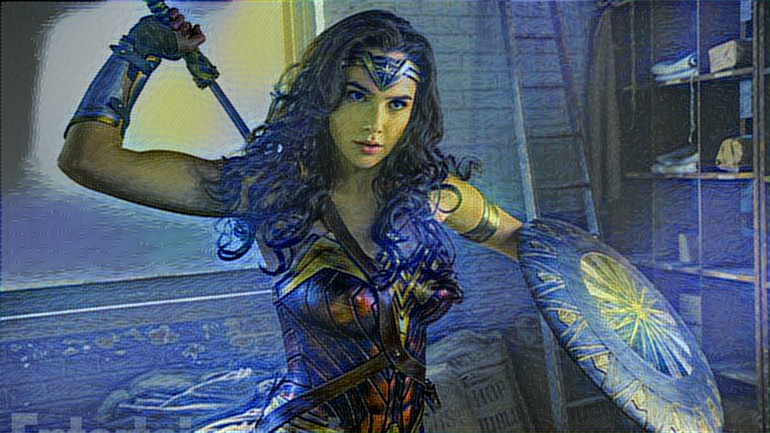

In [42]:
from IPython.display import Image
Image(output_path)